In [1]:
import pandas as pd
import tabulate as tb
import seaborn as sns
import matplotlib as plt
import numpy as np

In [2]:
# current = "211109"

In [3]:
def pullInfo(fn="illuminaRunTracker_MAINFILE.ods", engine="odf"):
    '''Pull information from the spreadsheet containing all run information.
    Requires odfpy to interpret. '''
    xl = pd.ExcelFile(fn, engine=engine)
    indexedSampleSheets = xl.sheet_names[2:]
    sheets = pd.read_excel(fn,
                           sheet_name=indexedSampleSheets)
    idx = pd.concat(sheets.values())  # concat all index values

#     runs = pd.read_excel(fn, sheet_name='run metrics, all runs',
#                          engine=engine)  # get parsed run metrics

    pools = pd.read_excel(fn, sheet_name='Calculated library pools',
                          engine=engine)  # get the goal library values
    idx['Lib Prep Date'] = pd.to_datetime(
        idx['Lib Prep Date'],
        format='%y%m%d')  # convert datetime; clean up indexed library values

#     for frame in [idx, runs, pools]:
    for frame in [idx, pools]:

        frame.columns = frame.columns.str.replace(
            ' ', '')  # clean up column names (again)
        frame.dropna(axis=1, how="all", inplace=True)
#     return idx, runs, pools
    return idx, pools

In [4]:
def reifyRunLibSums(idx):
    '''Sum each run information set for inter-run comparisons'''
    run_lib_Sums = idx.groupby(['Run', 'Library']).agg(
        {'%inrun': ['count', 'sum']}).reset_index()
    run_lib_Sums.columns = ["-".join(pair)
                            for pair in run_lib_Sums.columns]  # unstack multiindex
    run_lib_Sums = run_lib_Sums.rename({'Library-': 'Library',
                                        'Run-': "Run"}, axis=1)
    run_lib_Sums.columns = run_lib_Sums.columns.str.replace("run-", "run-lib-")
    
    return run_lib_Sums

def reifyLibSums(idx):
    '''Sum the actual numbers for library information set for inter-run-libcomparisons'''
    # group by run and get index run statistics
    idxSums = idx.groupby(['Run']).agg(
        {'%inrun': ['count', 'sum']}).reset_index()
    idxSums.columns = ["-".join(pair)
                       for pair in idxSums.columns]  # unstack multiindex
    idxSums = idxSums.rename({'Run-': 'Run'}, axis=1)  # reset run name
    # merge counted run indexing information with illumina outputs
    return idxSums

In [5]:
def clean(serie):
    '''Function to apply to a series to clean NaN and inf values for log scale issues'''
    output = serie[(np.isnan(serie) == False) & (np.isinf(serie) == False)]
    return output

In [6]:
indexedSamples, pools = pullInfo()
summed_interRun = reifyRunLibSums(indexedSamples)
summed_interRunLib = reifyLibSums(indexedSamples)
summed_idx_libs = summed_interRun.merge(summed_interRunLib)

In [7]:
runs = pd.read_csv('run_stats_all.txt')
runs = runs.drop(['Unnamed: 0', 'HrefBaseSpaceUI', 'Name', 'DateCreated',
           'DateModified', 'DateUploadStarted', 'DateUploadCompleted',
          'Number', 'ReagentBarcode', 'FlowcellBarcode', 'InstrumentName',
          'InstrumentType', 'PlatformName', 'Workflow',
       'NumCyclesRead1', 'NumCyclesRead2', 'NumCyclesIndex1',
       'NumCyclesIndex2', 'LaneAndQcStatus', 'LimsStatus', 'TotalSize',
       'IsFileDataDeleted', 'IsArchived', 'UserOwnedBy.Id', 'UserOwnedBy.GravatarUrl', 'UserOwnedBy.DateLastActive',
       'UserOwnedBy.DateCreated', 'Instrument.InstrumentId', 'Instrument.Name',
       'Instrument.SerialNumber'], axis=1)

In [82]:
merge1 = pd.merge(runs, indexedSamples, left_on ="ExperimentName", right_on = "Run")
merge2 = pd.merge(merge1, summed_idx_libs)
df = merge2.merge(pools)

In [83]:
# runs_spread = pd.merge(runs, summed_idx_libs, left_on = 'ExperimentName', right_on='Run')
# runs_spread = pd.merge(runs_spread, indexedSamples)

In [84]:
# run_sliced = runs[['ExperimentName', 'Reads_paired_PF', 'Id', 'DateCreated', 'LaneAndQcStatus' ,'SequencingStats.PercentPf']]

In [85]:
# df = runs_spread.merge(pools)

In [86]:
df['calculatedrun%'] = df['calculatedrunfractions']*100
df['PFReads_eaSample'] = df['Reads_paired_PF']*df['%inrun']
df['calculated%_eaSample'] = clean(df['calculatedrunfractions'] / \
    df['%inrun-lib-count']*100)

In [88]:
df['calculatedReads_eaSample'] = df['calculated%_eaSample'] * df['Reads_paired_PF']
df['%actual_over_planned'] = df['%inrun'] / df['calculated%_eaSample']
df['clean_actual_over_planned'] = clean(
    df['%actual_over_planned'])  # converts infs and NaN values
df['sample_classification'] = np.where(df.Sample.str.contains(
    "empty|NTC"), "NTC", "Sample")  # annotate with type of sample

In [89]:
# df clean(df['calculated%_eaSample'])

In [90]:
df.Run.unique()

array(['200527_KL', '200625_Bell02',
       '200713_KL-Davis05-AJE02-Bell03-DEB02', '200818_KL-AJE03-DEB03',
       '200909_Davis06-AJE03v2-Bell03', '200929_seq', '201104_seq',
       '201112_seq', '201119_RD01-RK-PB-PBF-V6', '210120_KL-31-32-33',
       '210212_KL-34-35-RK03', '210301_KL035-Davis08-RK03-AJE04-CWorg',
       '210819_KL039-CB10-JEF05-RD05', '210820_DMJ02-KL040-synG-nucv1',
       '210827_KLJJ01-CB10v2', '200427_KL',
       '211002_KL043-PBgenov2-Davis10-RD',
       '211109_KL-DEB06-JJ02-RD07-JSH01', '211205_JJ03-JEF07-DEB06-JDL01',
       '211214_JJ-Davis11-DEB07-JDL02-JSH02-RD09'], dtype=object)

In [91]:
current = '211214'

In [92]:
recent = df.query(f'Run.str.contains("{current}")').copy()

In [93]:
recent.Library.unique()

array(['JJ-Davis11-PBGeno', 'JJ-DEB07', 'JDL02-PCR1idx-val', 'JSH03',
       'RD08'], dtype=object)

In [94]:
table = recent.groupby("Library").sum()[['calculated%_eaSample', '%inrun']]
print(tb.tabulate(table, tablefmt="grid", headers=table.columns))

+-------------------+------------------------+----------+
|                   |   calculated%_eaSample |   %inrun |
+===================+========================+==========+
| JDL02-PCR1idx-val |                      0 |   0.1027 |
+-------------------+------------------------+----------+
| JJ-DEB07          |                     21 |  16.0152 |
+-------------------+------------------------+----------+
| JJ-Davis11-PBGeno |                     15 |  20.7431 |
+-------------------+------------------------+----------+
| JSH03             |                      7 |   7.9569 |
+-------------------+------------------------+----------+
| RD08              |                     38 |  34.9118 |
+-------------------+------------------------+----------+


Text(0.5, 1.18, 'Average % of each indexed sample \nin 211214 run')

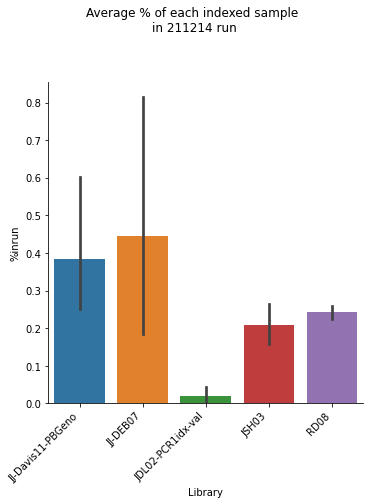

In [95]:
g = sns.catplot(data=recent, x="Library", y='%inrun', kind='bar')
title = f"Average % of each indexed sample \nin {current} run"
g.set_xticklabels(rotation=45, ha='right')
g.fig.suptitle(title, y=1.18)
# # g.set(yscale="log")

In [96]:
# g = sns.catplot(data = recent.query('~Sample.str.contains("empty|NTC")'),
#                 x = "Library",
#                 y ='%inrun',
#                 kind="swarm",
#                 hue = "Sample", legend=False, s = 3)

# title = f"Stripplot of sequencing distribution\nin {current} run, excluding NTCs"
# g.set_xticklabels(rotation=45, ha = 'right')
# # g.set(yscale="log")
# g.fig.suptitle(title, y = 1.18)
# g.fig.savefig(f"{current}_sequencingDistributionstripPlot.png", bbox_inches = "tight")#

In [97]:
# recent['total_reads_ratio'] = recent['calculate']

/home/kathleenleeper/.conda/envs/sequencingAnalysis/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 38.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


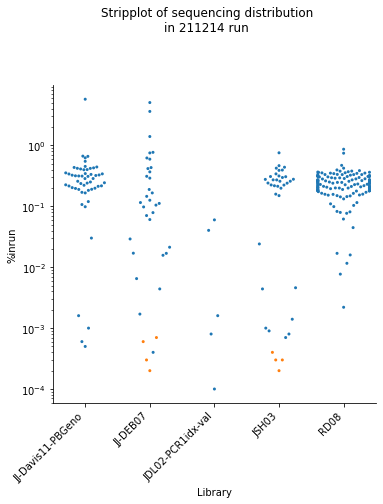

In [99]:
g = sns.catplot(data=recent,
                x="Library",
                y='%inrun',
                kind="swarm",
                hue="sample_classification", legend=False, s=3)

title = f"Stripplot of sequencing distribution\nin {current} run"
g.set_xticklabels(rotation=45, ha='right')
g.fig.suptitle(title, y=1.18)

log_on = True
if log_on:
    g.set(yscale="log")
    g.fig.savefig(f"{current}_sequencingDistributionstripPlot_log.png",
              bbox_inches="tight")
else:
    g.fig.savefig(f"{current}_sequencingDistributionstripPlot.png",
              bbox_inches="tight")

In [100]:
# df.groupby(['Mt'], sort=False)['count'].max()
# idx = df.groupby(['Mt'])['count'].transform(max) == df['count']
idx_min = recent.groupby("Library")['%actual_over_planned'].transform(
    min) == recent['%actual_over_planned']
idx_max = recent.groupby("Library")['%actual_over_planned'].transform(
    max) == recent['%actual_over_planned']

# recent.query("Library.str.contains('KL032-PB')").sort_values("%inrun", ascending = False)[['Sample','Library','%inrun', 'calculated%_eaSample', '%actual_over_planned',
#        'clean_actual_over_planned', 'sample_classification']]

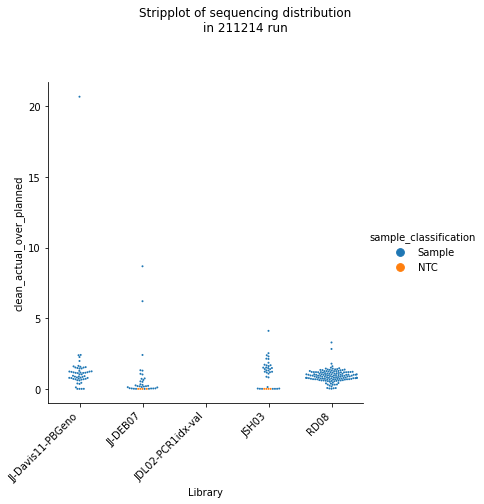

In [101]:
g = sns.catplot(data=recent,
                x="Library",
                y='clean_actual_over_planned',
                kind="swarm",
                hue="sample_classification", legend=True, s=2)

title = f"Stripplot of sequencing distribution\nin {current} run"
g.set_xticklabels(rotation=45, ha='right')
g.fig.suptitle(title, y=1.18)
g.fig.savefig(f"{current}_sequencingDistributionstripPlot.png",
              bbox_inches="tight")

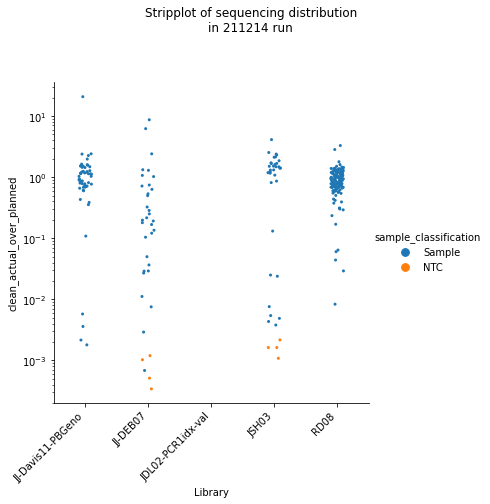

In [102]:
g = sns.catplot(data=recent,
                x="Library",
                y='clean_actual_over_planned',
                kind="strip",
                hue="sample_classification", legend=True, s=3)

title = f"Stripplot of sequencing distribution\nin {current} run"
g.set_xticklabels(rotation=45, ha='right')
g.set(yscale="log")
g.fig.suptitle(title, y=1.18)
g.fig.savefig(
    f"{current}_sequencingDistributionstripPlot_logScale.png", bbox_inches="tight")

/home/kathleenleeper/.conda/envs/sequencingAnalysis/lib/python3.8/site-packages/seaborn/categorical.py:1855: RuntimeWarning: divide by zero encountered in log2
  k = int(np.log2(n)) - 3


OverflowError: cannot convert float infinity to integer

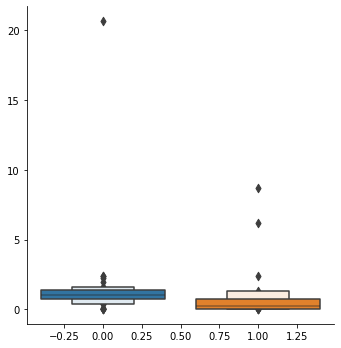

In [103]:
g = sns.catplot(data=recent.query('sample_classification.str.contains("Sample")'),
                x="Library", y='%actual_over_planned',
                kind="boxen")
g.set(yscale="log")
g.set_xticklabels(rotation=45, ha='right')
title = f"Boxenplot of sequencing distribution\nin {current} run, excluding NTCs"

g.fig.suptitle(title, y=1.18)
g.fig.savefig(
    f"{current}_sequencingDistributionsboxenPlot.png", bbox_inches="tight")

In [104]:
libSums = reifyLibSums(indexedSamples)

In [105]:
pltTime = recent.groupby("Library").agg(
    {'calculated%_eaSample': 'sum', '%inrun': 'sum'}).reset_index()
pltTime['ratio'] = pltTime['%inrun'] / pltTime['calculated%_eaSample']
# pltTime.to_clipboard(index = False)

In [106]:
# g = sns.relplot(data= recent, x  = 'calculated%_eaSample', y = '%inrun', hue = 'Library', style= "Library", estimator = np.mean, s= 200)

In [107]:
limit = round((pltTime['%inrun'].max()+5))
limit

40

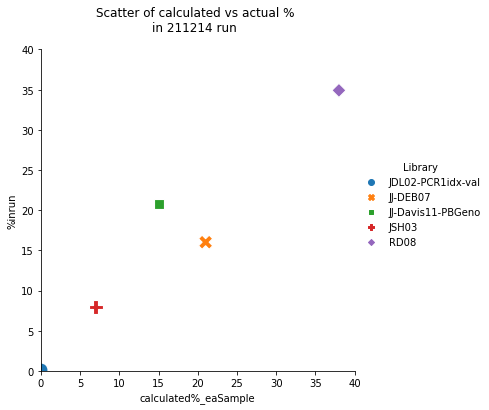

In [108]:
g = sns.relplot(data=pltTime, x='calculated%_eaSample',
                y='%inrun', hue='Library', style="Library", s=200)
# g = sns.lmplot(data= recent, x  = 'calculated%_eaSample', y = '%inrun', x_estimator=np.mean)
g.set(ylim=(0, limit), xlim=(0, limit))

title = f"Scatter of calculated vs actual %\nin {current} run"
# g.set(yscale="log")
g.fig.suptitle(title, y=1.09, x=.4)
g.fig.savefig(f"{current}_sequencingRatioScatter.png", bbox_inches="tight")

# DEPRECATED

In [ ]:
# df['%calc_to_actual'] = df['calculated%_eaSample']/df['%inrun']
g = sns.regplot(data=df.query(
    f'Run.str.contains("{current}")'), x='calculated%_eaSample', y='%inrun', units="Library")
# g.set(yscale="log")
# g.set_xticklabels(rotation=45, ha = 'right')

In [ ]:
versus['calculatedpctrun'] = versus['calculatedrunfractions']*100

In [ ]:
# grped = versus.query('Run.str.contains("11")').groupby(['Run', 'LibPrepDate', "Library" ]).agg({'calculatedpctrun':'median', 'Sample': 'count', '%inrun':'sum'}).reset_index()
# # grped.loc['Grand Total'] = grped.reset_index().sum()

In [ ]:
versus.groupby(['Run', 'LibPrepDate', "Library"]).agg(
    {'calculatedpctrun': 'median', 'Sample': 'count', '%inrun': 'sum'}).round(2)

In [ ]:
vs_grp = versus.groupby(['Run', 'LibPrepDate', "Library"]).agg(
    {'calculatedpctrun': 'median', 'Sample': 'count', '%inrun': 'sum', 'PCR1cycles': 'median', 'PCR2cycles': 'median', }).round(2)

In [ ]:
vs = vs_grp.reset_index()
vs['%persample'] = vs['calculatedpctrun']/vs['Sample']

In [ ]:
merged[['Run', '%inrun-count', '%inrun-sum',
        'Aligned(%)', '%readsundetermined', 'AlignedFrac-Undetermined', 'ErrorRate%', 'ClusterPF(%)', 'Density']].round(2)
# print(tb.tabulate(table, tablefmt="grid", headers = table.columns))

In [ ]:
# versus

In [ ]:
# sns.catplot(data=vs.query('',
#             y="%inrun",
#             x="Sample",
#             kind = "boxen", col = "Library")

In [ ]:
versus['calcVsActual_frac'] = versus['calculatedrunfractions']/versus['%inrun']

# versus['calcVsActual_Logfrac'] = np.log2(versus['calcVsActual_frac'])
recent = versus.query("Run.str.contains('2011')")
recent.query('Sample.str.contains("NTC")').sort_values(
    'calcVsActual_frac', ascending=False)

In [ ]:
g = sns.catplot(data=recent,
                y="%inrun",
                x="Library",
                kind="boxen")
#             hue="Library", height = 10)
g.set_xticklabels(rotation=45)
g.fig.suptitle("Boxenplot of % in run by library, excluding NTCs", y=1.05)
# g.fig.savefig("200929_sequencingDistributionBoxPlot", bbox_inches = "tight")

In [ ]:
g = sns.catplot(data=recent,
                y="calcVsActual_Logfrac",
                x="Library",
                kind="strip")
#                 , s= 3)
#             hue="Library", height = 10)
g.set_xticklabels(rotation=45, ha='right')
g.fig.suptitle(
    "Strip plot of calculated-to-actual % in run, excluding NTCs and any extreme outliers", y=1.05)
# g.savefig("200929_sequencingDistributionRatioStripplot.png", bbox_inches = "tight")

In [ ]:
recent.sort_values("calcVsActual", ascending=False)